#### Analyzing Neural Time Series Data
Python code for Chapter 26 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.io import loadmat
from scipy.signal import hilbert, morlet
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d
from scipy.stats import norm
import mne
from mne.time_frequency import tfr_array_morlet

In [2]:
# Load sample EEG dataset
eeg_data = loadmat('../data/sampleEEGdata.mat')
EEG = eeg_data['EEG'][0, 0]

# Names of the channels you want to synchronize
channel1 = 'P1'
channel2 = 'Pz'

# Create complex Morlet wavelet
center_freq = 5  # in Hz
time = np.arange(-1, 1 + 1/EEG['srate'][0][0], 1/EEG['srate'][0][0])  # time for wavelet
wavelet = np.exp(2 * 1j * np.pi * center_freq * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * center_freq))**2)) / center_freq
half_of_wavelet_size = (len(time) - 1) // 2

# FFT parameters
n_wavelet = len(time)
n_data = EEG['pnts'][0][0]
n_convolution = n_wavelet + n_data - 1

# FFT of wavelet
fft_wavelet = fft(wavelet, n_convolution)

# Initialize output time-frequency data
phase_data = np.zeros((2, EEG['pnts'][0][0]))
real_data = np.zeros((2, EEG['pnts'][0][0]))

# Find channel indices
chanidx = [EEG['chanlocs'][0]['labels']==channel1, EEG['chanlocs'][0]['labels']==channel2]

# Run convolution and extract filtered signal (real part) and phase
for chani in range(2):
    fft_data = fft(EEG['data'][chanidx[chani], :, 0], n_convolution)
    convolution_result_fft = ifft(fft_wavelet * fft_data, n_convolution) * np.sqrt(4 / (2 * np.pi * center_freq))
    convolution_result_fft = convolution_result_fft[0][half_of_wavelet_size:-half_of_wavelet_size]

    # Collect real and phase data
    phase_data[chani, :] = np.angle(convolution_result_fft)
    real_data[chani, :] = np.real(convolution_result_fft)

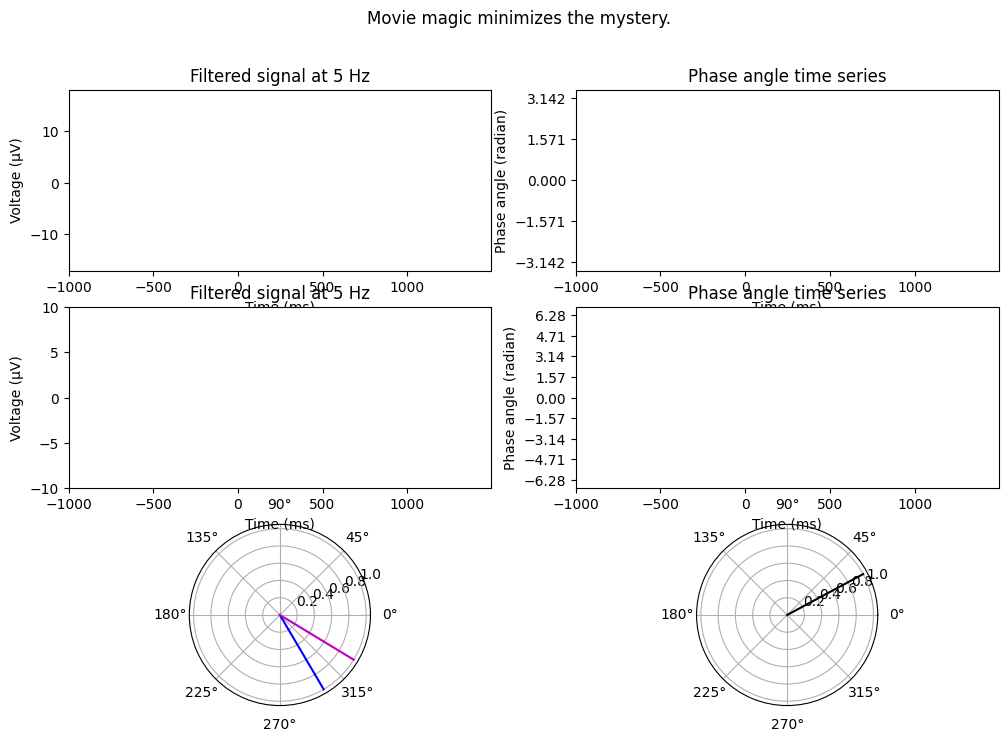

In [3]:
# Define the update function for the animation
def update(ti):
    # Update filtered signals
    filterplotH1.set_data(EEG['times'][0, :ti+1], real_data[0, :ti+1])
    filterplotH2.set_data(EEG['times'][0, :ti+1], real_data[1, :ti+1])

    # Update cartesian plot of phase angles
    phaseanglesH1.set_data(EEG['times'][0, :ti+1], phase_data[0, :ti+1])
    phaseanglesH2.set_data(EEG['times'][0, :ti+1], phase_data[1, :ti+1])

    # Update cartesian plot of phase angles differences
    phaseanglesDiffH1.set_data(EEG['times'][0, :ti+1], phase_data[0, :ti+1] - phase_data[1, :ti+1])
    filterplotDiffH1.set_data(EEG['times'][0, :ti+1], real_data[0, :ti+1] - real_data[1, :ti+1])

    # Update polar plot of phase angles
    ax1.clear()
    ax1.plot(np.tile(phase_data[0, :ti+1], 2), np.tile([0, 1], ti+1), 'b')
    ax1.plot(np.tile(phase_data[1, :ti+1], 2), np.tile([0, 1], ti+1), 'm')

    # Update polar plot of phase angle differences
    ax2.clear()
    ax2.plot(np.tile(phase_data[1, :ti+1] - phase_data[0, :ti+1], 2), np.tile([0, 1], ti+1), 'k')

    return filterplotH1, filterplotH2, phaseanglesH1, phaseanglesH2, phaseanglesDiffH1, filterplotDiffH1, ax1, ax2

# Create figure and axes
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(3, 2)
ax1 = fig.add_subplot(gs[2, 0], polar=True)
ax2 = fig.add_subplot(gs[2, 1], polar=True)
ax3 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[0, 1])
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
plt.suptitle('Movie magic minimizes the mystery.')

# Initial plot setup
filterplotH1, = ax3.plot(EEG['times'][0], real_data[0, :], 'b')
filterplotH2, = ax3.plot(EEG['times'][0], real_data[1, :], 'm')
ax3.set_xlim([EEG['times'][0][0], EEG['times'][0][-1]])
ax3.set_ylim([real_data.min(), real_data.max()])
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Voltage (μV)')
ax3.set_title(f'Filtered signal at {center_freq} Hz')

phaseanglesH1, = ax4.plot(EEG['times'][0], phase_data[0, :], 'b')
phaseanglesH2, = ax4.plot(EEG['times'][0], phase_data[1, :], 'm')
ax4.set_xlim([EEG['times'][0][0], EEG['times'][0][-1]])
ax4.set_ylim([-np.pi * 1.1, np.pi * 1.1])
ax4.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('Phase angle (radian)')
ax4.set_title('Phase angle time series')

filterplotDiffH1, = ax5.plot(EEG['times'][0], real_data[0, :] - real_data[1, :], 'b')
ax5.set_xlim([EEG['times'][0][0], EEG['times'][0][-1]])
ax5.set_ylim([-10, 10])
ax5.set_xlabel('Time (ms)')
ax5.set_ylabel('Voltage (μV)')
ax5.set_title(f'Filtered signal at {center_freq} Hz')

phaseanglesDiffH1, = ax6.plot(EEG['times'][0], phase_data[0, :] - phase_data[1, :], 'b')
ax6.set_xlim([EEG['times'][0][0], EEG['times'][0][-1]])
ax6.set_ylim([-np.pi * 2.2, np.pi * 2.2])
ax6.set_yticks([-2*np.pi, -3*np.pi/2, -np.pi, -np.pi/2, 0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax6.set_xlabel('Time (ms)')
ax6.set_ylabel('Phase angle (radian)')
ax6.set_title('Phase angle time series')

# Create the animation
ani = FuncAnimation(fig, update, frames=np.arange(0, EEG['pnts'][0][0], 10), interval=100, blit=False)

# Display the animation in the Jupyter notebook
HTML(ani.to_html5_video())

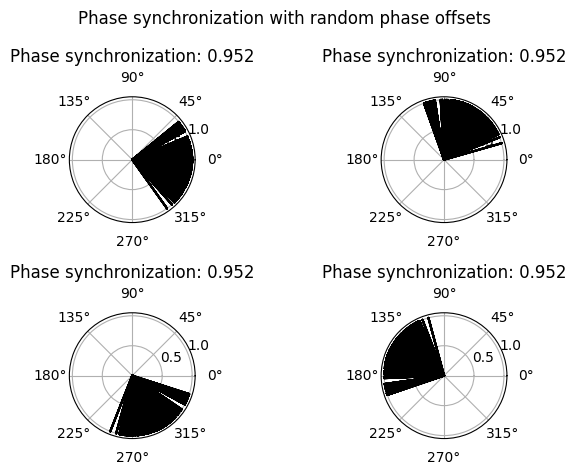

In [4]:
# Figure 26.2

# Set up the figure
fig, axs = plt.subplots(2, 2, subplot_kw={'polar': True})
fig.suptitle('Phase synchronization with random phase offsets')

# Plot initial phase synchronization in polar space
axs[0, 0].plot(np.tile(phase_data[1, :] - phase_data[0, :], 2), np.tile([0, 1], EEG['pnts'][0][0]), 'k')
axs[0, 0].set_title(f"Phase synchronization: {np.abs(np.mean(np.exp(1j * (np.diff(phase_data, axis=0))))):.3f}")

# Generate new phase data with random phase offsets and plot
new_phase_data = phase_data.copy()
for i in range(1, 4):
    # Add random phase offset
    new_phase_data[0, :] = new_phase_data[0, :] + np.random.rand() * np.pi
    
    # Plot again
    axs[i // 2, i % 2].plot(np.tile(new_phase_data[1, :] - new_phase_data[0, :] + np.pi/2, 2),
                            np.tile([0, 1], EEG['pnts'][0][0]), 'k')
    axs[i // 2, i % 2].set_title(f"Phase synchronization: {np.abs(np.mean(np.exp(1j * (np.diff(new_phase_data, axis=0))))):.3f}")

plt.tight_layout()
plt.show()

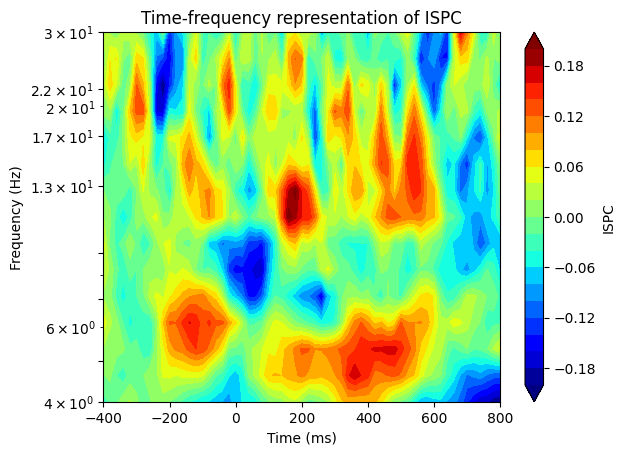

In [45]:
# Figure 26.3

# Define channels and frequencies
channel1 = 'Fz'
channel2 = 'O1'
freqs2use = np.logspace(np.log10(4), np.log10(30), 15)  # 4-30 Hz in 15 steps
times2save = np.arange(-400, 801, 20)  # Time points to save
timewindow = np.linspace(1.5, 3, len(freqs2use))  # Number of cycles on either end of the center point
baselinetm = [-400, -200]

# Wavelet and FFT parameters
time = np.arange(-1, 1 + 1/EEG['srate'][0][0], 1/EEG['srate'][0][0])
half_wavelet = (len(time) - 1) // 2
num_cycles = np.logspace(np.log10(4), np.log10(8), len(freqs2use))
n_wavelet = len(time)
n_data = EEG['pnts'][0][0] * EEG['trials'][0][0]
n_convolution = n_wavelet + n_data - 1

# Time in indices
times2saveidx = np.array([np.argmin(np.abs(EEG['times'][0] - t)) for t in times2save])
baselineidx = np.array([np.argmin(np.abs(times2save - bt)) for bt in baselinetm])

# Find channel indices
chanidx = [EEG['chanlocs'][0]['labels']==channel1, EEG['chanlocs'][0]['labels']==channel2]

# Initialize ISPC matrix
ispc = np.zeros((len(freqs2use), len(times2save)))
ps = np.zeros((len(freqs2use), len(times2save)))

# Data FFTs
data_fft1 = fft(EEG['data'][chanidx[0], :, :].flatten('F'), n_convolution)
data_fft2 = fft(EEG['data'][chanidx[1], :, :].flatten('F'), n_convolution)

# Loop over frequencies
for fi, freq in enumerate(freqs2use):
    # Create wavelet and take FFT
    s = num_cycles[fi] / (2 * np.pi * freq)
    wavelet = np.exp(2 * 1j * np.pi * freqs2use[fi] * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * freqs2use[fi]))**2)) / freqs2use[fi]
    wavelet_fft = fft(wavelet, n_convolution)
    
    # Phase angles from channel 1 via convolution
    convolution_result_fft = ifft(wavelet_fft * data_fft1, n_convolution)
    convolution_result_fft = convolution_result_fft[half_wavelet:-half_wavelet]
    phase_sig1 = np.angle(np.reshape(convolution_result_fft, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F'))
    
    # Phase angles from channel 2 via convolution
    convolution_result_fft = ifft(wavelet_fft * data_fft2, n_convolution)
    convolution_result_fft = convolution_result_fft[half_wavelet:-half_wavelet]
    phase_sig2 = np.angle(np.reshape(convolution_result_fft, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F'))
    
    # Phase angle differences
    phase_diffs = phase_sig1 - phase_sig2
    
    # Compute ISPC over trials
    ispc[fi, :] = np.abs(np.mean(np.exp(1j * phase_diffs[times2saveidx, :]), axis=1))
    ps[fi, :] = np.abs(np.mean(np.exp(1j * phase_diffs[times2saveidx, :]), axis=1))

# Baseline subtraction
ispc = ispc - np.mean(ispc[:, baselineidx[0]:baselineidx[1]], axis=1)[:, None]

# Plotting
plt.figure()
plt.contourf(times2save, freqs2use, ispc, 20, cmap='jet', extend='both')
plt.yscale('log')
plt.yticks(np.round(np.logspace(np.log10(freqs2use[0]), np.log10(freqs2use[-1]), 8)))
plt.colorbar(label='ISPC')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('Time-frequency representation of ISPC')
plt.show()

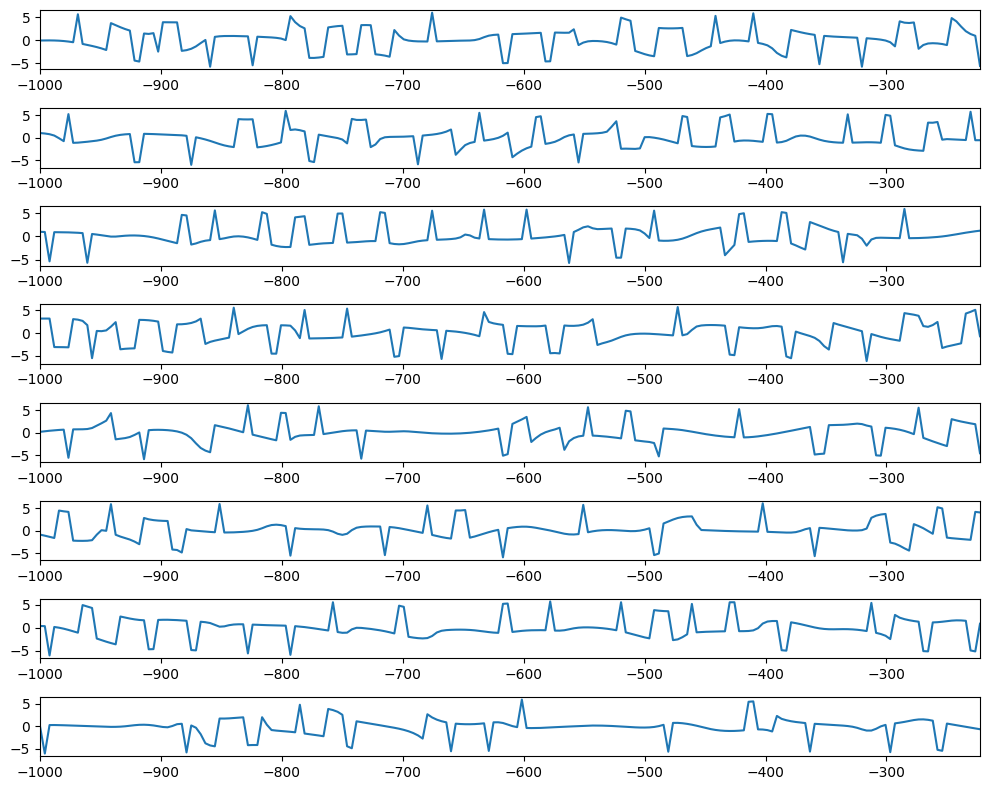

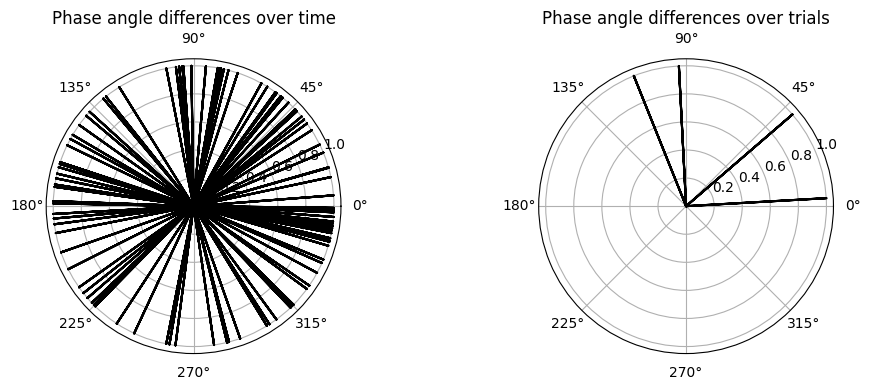

In [46]:
# Figure 26.4
plt.figure(figsize=(10, 8))

# Plot phase differences over time for the first 8 trials
for i in range(8):
    plt.subplot(8, 1, i + 1)
    plt.plot(EEG['times'][0][:200], phase_sig1[:200, i] - phase_sig2[:200, i])
    plt.xlim(EEG['times'][0][0], EEG['times'][0][199])

plt.tight_layout()
plt.show()

# Plot phase angle differences over time for the first trial in polar coordinates
plt.figure(figsize=(10, 4))
plt.subplot(121, projection='polar')
plt.plot(np.tile(phase_sig1[:200, 0] - phase_sig2[:200, 0], 2), np.tile([0, 1], 200), 'k')
plt.title('Phase angle differences over time')

# Plot phase angle differences over trials at a specific time point in polar coordinates
plt.subplot(122, projection='polar')
plt.plot(np.tile(phase_sig1[100, :8] - phase_sig2[100, :8], 2), np.tile([0, 1], 8), 'k')
plt.title('Phase angle differences over trials')

plt.tight_layout()
plt.show()

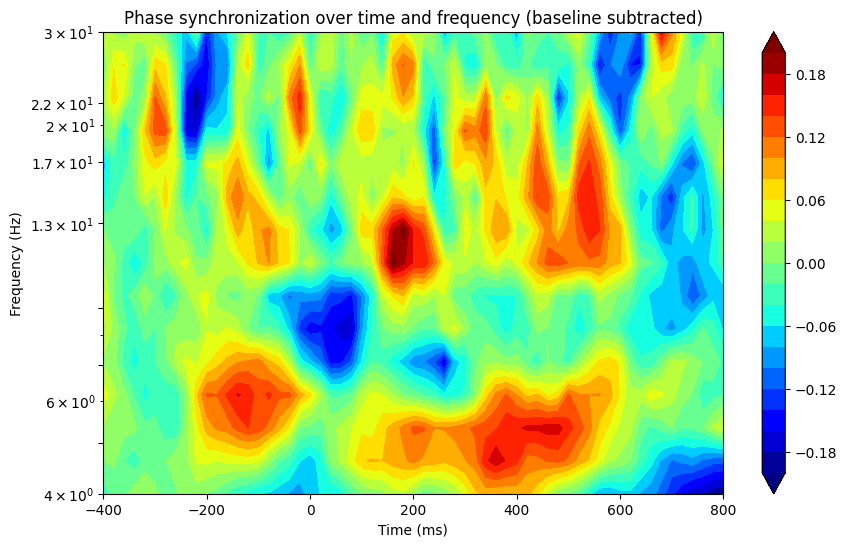

In [47]:
# Figure 26.5
plt.figure(figsize=(10, 6))
# Baseline subtraction
ps_baseline_subtracted = ps - np.mean(ps[:, baselineidx[0]:baselineidx[1]], axis=1, keepdims=True)
# Plotting
plt.contourf(times2save, freqs2use, ps_baseline_subtracted, 20, cmap='jet', extend='both')
plt.yscale('log')
plt.yticks(np.round(np.logspace(np.log10(freqs2use[0]), np.log10(freqs2use[-1]), 8)))
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.title('Phase synchronization over time and frequency (baseline subtracted)')
plt.show()

/Users/kylemcgraw/.pyenv/versions/3.10.12/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kylemcgraw/.pyenv/versions/3.10.12/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


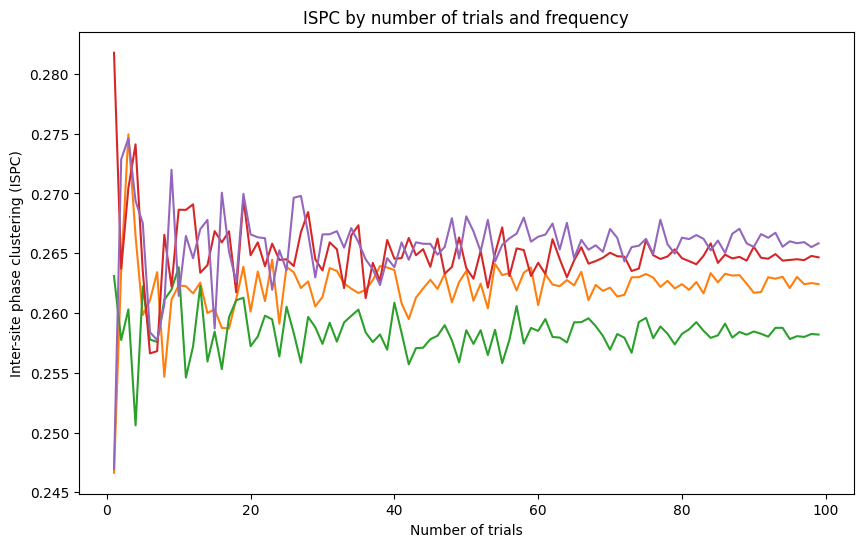

In [60]:
# Figure 26.6
time2use = 300  # ms
niterations = 50  # you can decrease this to make the code a bit faster

# Initialize
ispcByNandF = np.zeros((len(freqs2use), EEG['trials'][0][0]))
time2useidx = np.argmin(np.abs(times2save - time2use))

# Loop over frequencies
for fi, freq in enumerate(freqs2use):
    # Compute time window in indices for this frequency
    time_window_idx = np.round((1000 / freq) * timewindow[fi] / (1000 / EEG['srate'][0][0])).astype(int)
    
    # Phase angles from channel 1 via convolution
    convolution_result_fft = ifft(wavelet_fft * data_fft1, n_convolution)
    convolution_result_fft = convolution_result_fft[half_wavelet:-half_wavelet]
    phase_sig1 = np.angle(np.reshape(convolution_result_fft, (EEG['pnts'][0][0], EEG['trials'][0][0])))
    
    # Phase angles from channel 2 via convolution
    convolution_result_fft = ifft(wavelet_fft * data_fft2, n_convolution)
    convolution_result_fft = convolution_result_fft[half_wavelet:-half_wavelet]
    phase_sig2 = np.angle(np.reshape(convolution_result_fft, (EEG['pnts'][0][0], EEG['trials'][0][0])))
    
    # Phase angle differences
    phase_diffs = phase_sig1 - phase_sig2
    
    for n in range(1, EEG['trials'][0][0] + 1):
        # Multiple iterations to select different random sets of trials
        for iteri in range(niterations):
            trials2use = np.random.choice(EEG['trials'][0][0], n, replace=False)
            ispcByNandF[fi, n - 1] += np.mean(np.abs(np.mean(np.exp(1j * phase_diffs[time2useidx - time_window_idx:time2useidx + time_window_idx, trials2use]), axis=0)))

# Normalize by number of iterations
ispcByNandF /= niterations

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, EEG['trials'][0][0] + 1), ispcByNandF.T)
plt.xlabel('Number of trials')
plt.ylabel('Inter-site phase clustering (ISPC)')
plt.title('ISPC by number of trials and frequency')
plt.show()